# Excercises 
# 1. Tune the network
Run the experiment below, explore the different parameters (see suggestions below) and study the result with tensorboard. 
Make a single page (1 a4) report of your findings. Use your visualisation skills to communicate your most important findings.

You follow this cycle:
- make a hypothesis
- design an experiment
- run the experiment
- analyze the results and draw conclusions
- repeat


In [1]:
from mads_datasets import DatasetFactoryProvider, DatasetType

from mltrainer.preprocessors import BasePreprocessor
from mltrainer import imagemodels, Trainer, TrainerSettings, ReportTypes, metrics

import torch.optim as optim
from torch import nn
from tomlserializer import TOMLSerializer

We will be using `tomlserializer` to easily keep track of our experiments, and to easily save the different things we did during our experiments.
It can export things like settings and models to a simple `toml` file, which can be easily shared, checked and modified.

First, we need the data. 

In [2]:
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
preprocessor = BasePreprocessor()
streamers = fashionfactory.create_datastreamer(batchsize=64, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]
trainstreamer = train.stream()
validstreamer = valid.stream()

2025-09-16 20:48:06.721 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/christelvanharen/.cache/mads_datasets/fashionmnist
2025-09-16 20:48:06.722 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/christelvanharen/.cache/mads_datasets/fashionmnist/fashionmnist.pt


We need a way to determine how well our model is performing. We will use accuracy as a metric.

In [3]:
accuracy = metrics.Accuracy()

You can set up a single experiment.

- We will show the model batches of 64 images, 
- and for every epoch we will show the model 100 batches (trainsteps=100).
- then, we will test how well the model is doing on unseen data (teststeps=100).
- we will report our results during training to tensorboard, and report all configuration to a toml file.
- we will log the results into a directory called "modellogs", but you could change this to whatever you want.

In [4]:
import torch
loss_fn = torch.nn.CrossEntropyLoss()

settings = TrainerSettings(
    epochs=3,
    metrics=[accuracy],
    logdir="modellogs",
    train_steps=100,
    valid_steps=100,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
)


We will use a very basic model: a model with three linear layers.

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes: int, units1: int, units2: int) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.units1 = units1
        self.units2 = units2
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, units1),
            nn.ReLU(),
            nn.Linear(units1, units2),
            nn.ReLU(),
            nn.Linear(units2, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork(
    num_classes=10, units1=256, units2=256)

I developped the `tomlserializer` package, it is a useful tool to save configs, models and settings as a tomlfile; that way it is easy to track what you changed during your experiments.

This package will 1. check if there is a `__dict__` attribute available, and if so, it will use that to extract the parameters that do not start with an underscore, like this:

In [6]:
{k: v for k, v in model.__dict__.items() if not k.startswith("_")}

{'training': True, 'num_classes': 10, 'units1': 256, 'units2': 256}

This means that if you want to add more parameters to the `.toml` file, eg `units3`, you can add them to the class like this:

```python
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes: int, units1: int, units2: int, units3: int) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.units1 = units1
        self.units2 = units2
        self.units3 = units3  # <-- add this line
```

And then it will be added to the `.toml` file. Check the result for yourself by using the `.save()` method of the `TomlSerializer` class like this:

In [7]:
tomlserializer = TOMLSerializer()
tomlserializer.save(settings, "settings.toml")
tomlserializer.save(model, "model.toml")

Check the `settings.toml` and `model.toml` files to see what is in there.

You can use the `Trainer` class from my `mltrainer` module to train your model. It has the TOMLserializer integrated, so it will automatically save the settings and model to a toml file if you have added `TOML` as a reporttype in the settings.

In [8]:
trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
)
trainer.loop()

2025-09-16 20:48:06.778 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20250916-204806
2025-09-16 20:48:07.686 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 100/100 [00:00<00:00, 339.59it/s]
2025-09-16 20:48:08.180 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.9360 test 0.7185 metric ['0.7341']
100%|██████████| 100/100 [00:00<00:00, 380.41it/s]
2025-09-16 20:48:08.551 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.5687 test 0.5508 metric ['0.8011']
100%|██████████| 100/100 [00:00<00:00, 380.24it/s]
2025-09-16 20:48:08.923 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.5049 test 0.5314 metric ['0.8058']
100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Now, check in the modellogs directory the results of your experiment.

We can now loop this with a naive approach, called a grid-search (why do you think i call it naive?).

In [9]:
units = [256, 128, 64]
for unit1 in units:
    for unit2 in units:
        print(f"Units: {unit1}, {unit2}")

Units: 256, 256
Units: 256, 128
Units: 256, 64
Units: 128, 256
Units: 128, 128
Units: 128, 64
Units: 64, 256
Units: 64, 128
Units: 64, 64


Of course, this might not be the best way to search for a model; some configurations will be better than others (can you predict up front what will be the best configuration?).

So, feel free to improve upon the gridsearch by adding your own logic.

In [10]:
import torch

units = [256, 128, 64]
loss_fn = torch.nn.CrossEntropyLoss()

settings = TrainerSettings(
    epochs=3,
    metrics=[accuracy],
    logdir="modellogs",
    train_steps=len(train),
    valid_steps=len(valid),
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
)

for unit1 in units:
    for unit2 in units:

        model = NeuralNetwork(num_classes=10, units1=unit1, units2=unit2)

        trainer = Trainer(
            model=model,
            settings=settings,
            loss_fn=loss_fn,
            optimizer=optim.Adam,
            traindataloader=trainstreamer,
            validdataloader=validstreamer,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau
        )
        trainer.loop()


2025-09-16 20:48:08.934 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20250916-204808
2025-09-16 20:48:08.935 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 937/937 [00:02<00:00, 382.64it/s]
2025-09-16 20:48:11.575 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.5139 test 0.4415 metric ['0.8373']
100%|██████████| 937/937 [00:02<00:00, 376.78it/s]
2025-09-16 20:48:14.233 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.3681 test 0.3797 metric ['0.8627']
100%|██████████| 937/937 [00:02<00:00, 374.49it/s]
2025-09-16 20:48:16.908 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.3265 test 0.3718 metric ['0.8631']
100%|██████████| 3/3 [00:07<00:00,  2.65s/it]
2025-09-16 20:48:16.909 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20250916-204816
2025-09-16 20:48:16.910 | INFO     | mltrainer.trainer:__init__:68

Because we have set the ReportType to TOML, you will find in every log dir a model.toml and settings.toml file.

Run the experiment, and study the result with tensorboard. 

Locally, it is easy to do that with VS code itself. On the server, you have to take these steps:

- in the terminal, `cd` to the location of the repository
- activate the python environment for the shell. Note how the correct environment is being activated.
- run `tensorboard --logdir=modellogs` in the terminal
- tensorboard will launch at `localhost:6006` and vscode will notify you that the port is forwarded
- you can either press the `launch` button in VScode or open your local browser at `localhost:6006`

## Analyze grid-search results
The cells below load the saved TensorBoard runs from `modellogs`, combine them with the hyperparameter configuration, and visualise how each setting performs. Run them after finishing the grid search to explore the results without leaving the notebook.

> **Note**: The visualisations rely on `pandas`, `matplotlib`, `seaborn`, and the TensorBoard event reader. Install missing packages with `pip install pandas matplotlib seaborn tensorboard` in the active environment before executing the code.

In [11]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

try:
    import tomllib  # Python 3.11+
except ModuleNotFoundError:  # pragma: no cover
    import tomli as tomllib

sns.set_theme(style="whitegrid")
log_root = Path("modellogs")
run_dirs = sorted(d for d in log_root.iterdir() if d.is_dir())
if not run_dirs:
    raise RuntimeError("No runs found in 'modellogs'. Train the grid search before visualising.")


In [12]:
def load_run_history(run_dir: Path) -> pd.DataFrame:
    """Collect scalar metrics for a single run directory."""
    model_path = run_dir / "model.toml"
    if not model_path.exists():
        return pd.DataFrame()

    with model_path.open("rb") as fh:
        model_cfg = tomllib.load(fh).get("model", {})

    units1 = model_cfg.get("units1")
    units2 = model_cfg.get("units2")

    try:
        accumulator = EventAccumulator(str(run_dir))
        accumulator.Reload()
    except Exception as exc:  # pragma: no cover
        print(f"Skipping {run_dir.name}: {exc}")
        return pd.DataFrame()

    records = []
    for tag in accumulator.Tags().get("scalars", []):
        for event in accumulator.Scalars(tag):
            records.append(
                {
                    "run": run_dir.name,
                    "tag": tag,
                    "step": event.step,
                    "value": event.value,
                    "units1": units1,
                    "units2": units2,
                }
            )

    return pd.DataFrame.from_records(records)

history_frames = [df for df in (load_run_history(run_dir) for run_dir in run_dirs) if not df.empty]
if not history_frames:
    raise RuntimeError("No scalar metrics found. Ensure TensorBoard logs exist in 'modellogs'.")

history_df = (
    pd.concat(history_frames, ignore_index=True)
    .dropna(subset=["tag"])
    .sort_values(["units1", "units2", "tag", "step"])
)
history_df["units_combo"] = history_df["units1"].astype(str) + " → " + history_df["units2"].astype(str)
history_df.head()


,run,tag,step,value,units1,units2,units_combo
111,20250915-150522,Loss/test,0,0.458777,64,64,64 → 64
231,20250916-192641,Loss/test,0,0.447537,64,64,64 → 64
351,20250916-204731,Loss/test,0,0.451709,64,64,64 → 64
471,20250916-204902,Loss/test,0,0.456492,64,64,64 → 64
112,20250915-150522,Loss/test,1,0.415448,64,64,64 → 64


In [13]:
summary_df = (
    history_df.groupby(["run", "units1", "units2", "tag"])
    .tail(1)
    .pivot(index=["run", "units1", "units2"], columns="tag", values="value")
    .reset_index()
    .sort_values(["units1", "units2", "run"])
)
summary_df


tag,run,units1,units2,Loss/test,Loss/train,learning_rate,metric/Accuracy
9,20250915-150522,64,64,0.386667,0.372812,0.001,0.859175
19,20250916-192641,64,64,0.370399,0.363819,0.001,0.869391
29,20250916-204731,64,64,0.398419,0.366583,0.001,0.858974
39,20250916-204902,64,64,0.400397,0.367559,0.001,0.859275
8,20250915-150516,64,128,0.389917,0.360692,0.001,0.858974
18,20250916-192636,64,128,0.388878,0.357066,0.001,0.859475
28,20250916-204726,64,128,0.387449,0.356301,0.001,0.860377
38,20250916-204856,64,128,0.390574,0.360645,0.001,0.859876
7,20250915-150510,64,256,0.364236,0.345115,0.001,0.867688
17,20250916-192630,64,256,0.368300,0.355978,0.001,0.868690


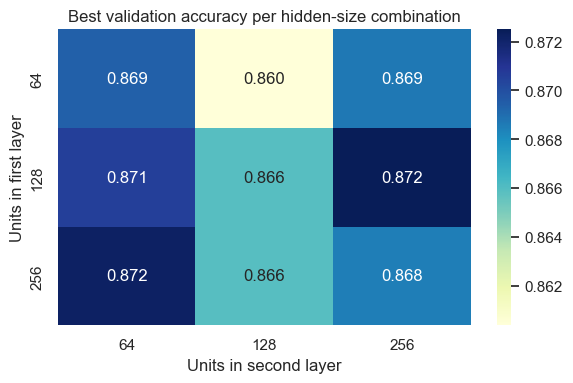

In [14]:
if "metric/Accuracy" in summary_df:
    accuracy_grid = (
        summary_df.groupby(["units1", "units2"])
        ["metric/Accuracy"]
        .max()
        .unstack("units2")
    )

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(accuracy_grid, annot=True, fmt=".3f", cmap="YlGnBu", ax=ax)
    ax.set_title("Best validation accuracy per hidden-size combination")
    ax.set_xlabel("Units in second layer")
    ax.set_ylabel("Units in first layer")
    plt.tight_layout()
else:
    raise KeyError("The TensorBoard logs do not contain a 'metric/Accuracy' scalar.")


/var/folders/fn/w77c6xmn193fjb8f9fh71x100000gn/T/ipykernel_48824/1633387285.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/fn/w77c6xmn193fjb8f9fh71x100000gn/T/ipykernel_48824/1633387285.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/var/folders/fn/w77c6xmn193fjb8f9fh71x100000gn/T/ipykernel_48824/1633387285.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


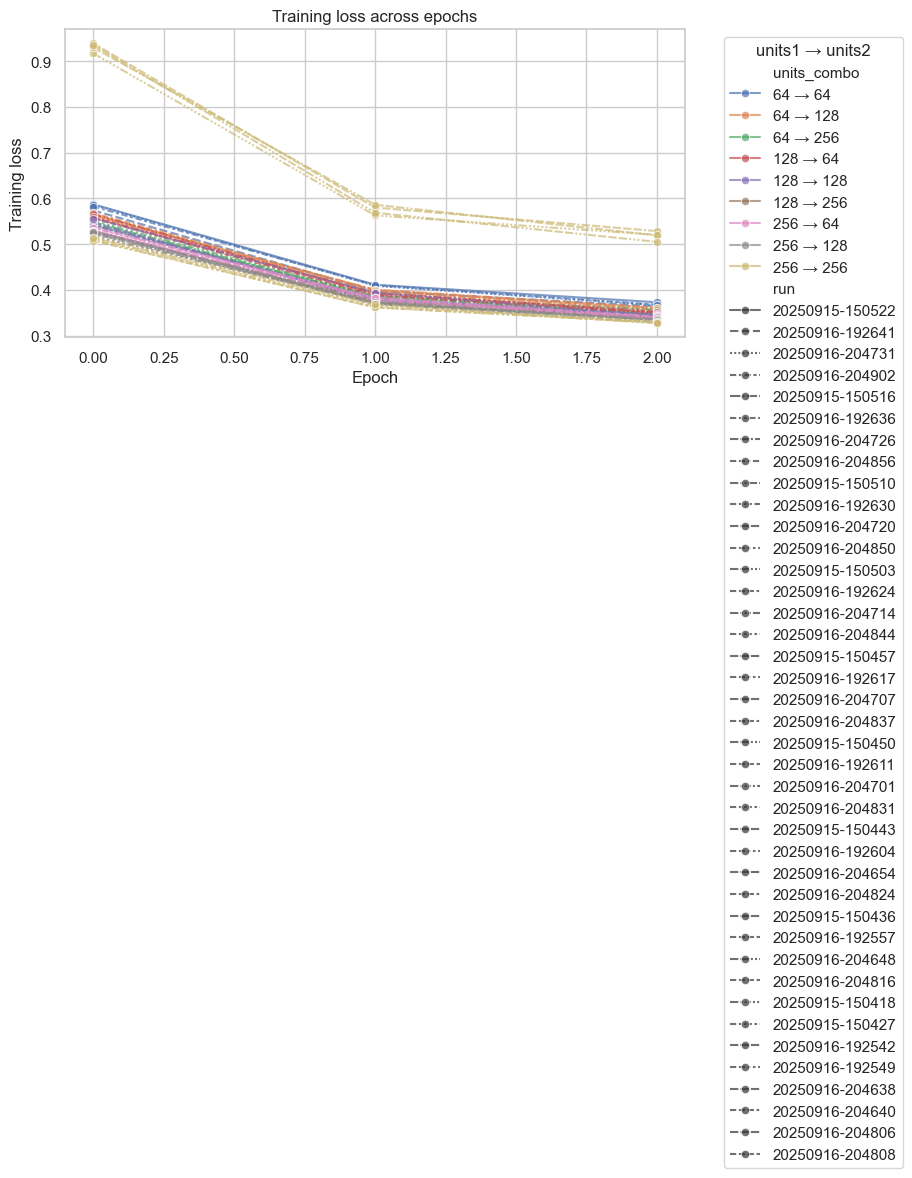

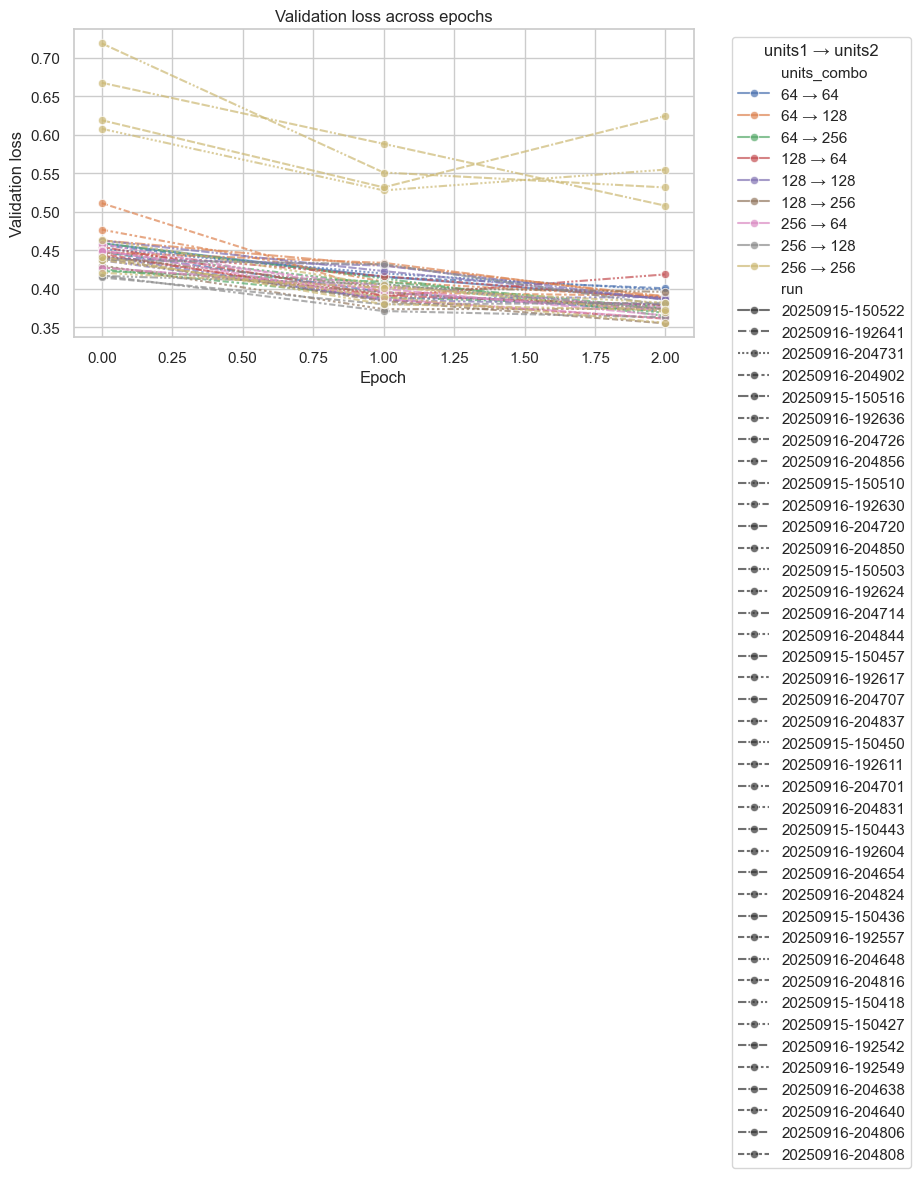

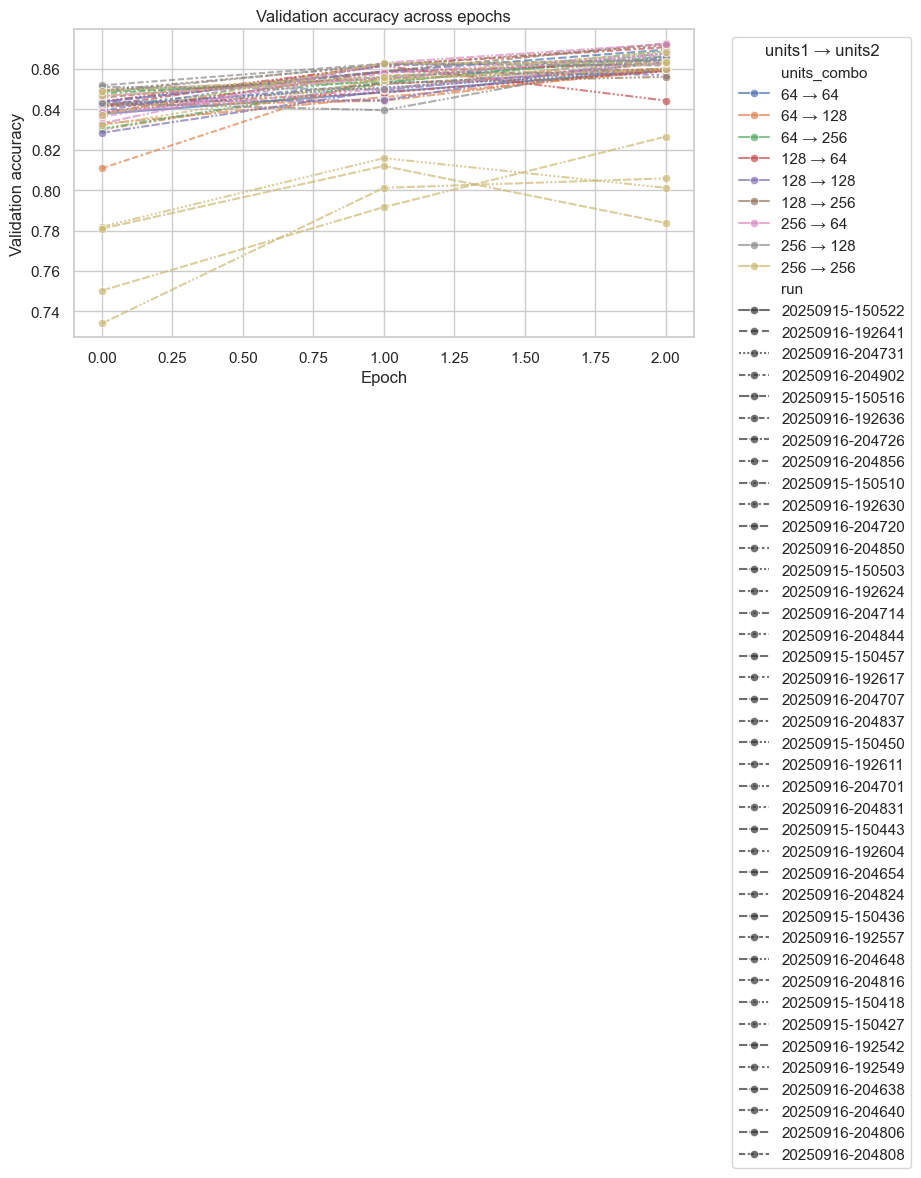

In [15]:
def plot_metric(tag: str, ylabel: str) -> None:
    metric_df = history_df[history_df["tag"] == tag]
    if metric_df.empty:
        raise KeyError(f"No scalar data found for {tag!r}.")

    fig, ax = plt.subplots(figsize=(8, 4))
    sns.lineplot(
        data=metric_df,
        x="step",
        y="value",
        hue="units_combo",
        style="run",
        marker="o",
        alpha=0.7,
        ax=ax,
    )
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{ylabel} across epochs")
    ax.legend(title="units1 → units2", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()

plot_metric("Loss/train", "Training loss")
plot_metric("Loss/test", "Validation loss")
plot_metric("metric/Accuracy", "Validation accuracy")
